In [1]:
! pip install bs4
! pip install requests
! pip install selenium
! pip install webdriver-manager
! pip install scikit-learn

In [3]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import requests
import csv
import re
import ast
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
%matplotlib inline

# Data acquisition and storage.

## 1.Find book names and book links:

This function extracts the book names and their links.
The function receives the URL, the number of pages we will run on and
the limit of books for this category (printed, digital, audio).

In [3]:
def book_links(base_url,num_pages,limit):
    # opening a browser
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=Options())
    urls = []
    titles = []
    # Going over the pages and extracting the links and names.
    for page in range(1, num_pages + 1):
        url = base_url.format(page=page)
        driver.get(url)
        wait = WebDriverWait(driver, 10)
        book_links = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'product-image')))
        for link in book_links:
            href = link.get_attribute('href')
            clean_href = href.replace('https://www.e-vrit.co.il/https://', '')
            urls.append(clean_href)
            titles.append(link.get_attribute('title'))
        if len(urls) >= limit:
            break
    df = pd.DataFrame({'שם הספר': titles[:limit],'קישור': urls[:limit]})
    # closing the browser
    driver.quit()
    return df

# The 3 URLs: d_url = digital, p_url = printed , a_url = audio.
d_url = 'https://www.e-vrit.co.il/Group/5543/%D7%A1%D7%A4%D7%A8%D7%99%D7%9D_%D7%93%D7%99%D7%92%D7%99%D7%98%D7%9C%D7%99%D7%99%D7%9D___?page={page}&sortType=4'
p_url = 'https://www.e-vrit.co.il/Group/5545/%D7%A1%D7%A4%D7%A8%D7%99%D7%9D_%D7%9E%D7%95%D7%93%D7%A4%D7%A1%D7%99%D7%9D___?page={page}&sortType=4'
o_url = 'https://www.e-vrit.co.il/Group/5544/%D7%A1%D7%A4%D7%A8%D7%99%D7%9D_%D7%A7%D7%95%D7%9C%D7%99%D7%99%D7%9D___?page={page}&sortType=4'
# DataFrame to store the digital, printed and audio DataFrame.
result_df = pd.DataFrame()
df_d = book_links(d_url,70,2100) 
df_p = book_links(p_url,70,2100)
df_o = book_links(o_url,40,1200) 
result_df = pd.concat([result_df, df_d,df_p,df_o], ignore_index=True)
display(result_df)

#create a csv file from the DataFrame
result_df.to_csv('C:/Users/maaya/Downloads/books_names_and_links.csv', index=False)

[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.30M/6.30M [00:00<00:00, 23.3MB/s]


,שם הספר,קישור
0,מארז המועמדת,https://www.e-vrit.co.il/Product/17521/%D7%9E%...
1,המועמדת,https://www.e-vrit.co.il/Product/4347/%D7%94%D...
2,מארז פראי,https://www.e-vrit.co.il/Product/17347/%D7%9E%...
3,מארז נישואים למיליארדר,https://www.e-vrit.co.il/Product/17433/%D7%9E%...
4,השתלטות עוינת,https://www.e-vrit.co.il/Product/104/%D7%94%D7...
...,...,...
5395,המשימה האבודה,https://www.e-vrit.co.il/Product/24544/%D7%94%...
5396,קוטפת השקדים,https://www.e-vrit.co.il/Product/9599/%D7%A7%D...
5397,נמר בוער-ניסים אלוני,https://www.e-vrit.co.il/Product/9950/%D7%A0%D...
5398,שדרות אפלות,https://www.e-vrit.co.il/Product/9285/%D7%A9%D...


## 2.Find book details:

This function goes through all the links, of each book and extracts the following characteristics from it: the name of the book, the name of the author, the number of stars, the number of comments, whether the book is digital, printed, audio, whether there is a translation of the book, the name of the publisher, the date of publication, the number of pages , genre, is there a summary, is the first chapter available to read on the website, is there a link to external reviews, is the book a bestseller (sold thousands or hundreds).

In [22]:
def book_data(url):
    time.sleep(1)
    response = requests.get(url)
    if response.status_code == 200:
        page_content = response.content
        soup = BeautifulSoup(page_content, 'html.parser')

        author_name = soup.find("div", attrs={"class": "headlines__book-author"})
        if author_name:
            authors_list.append(author_name.get_text().strip())
        else:
            authors_list.append("Unknown")

        reviews = soup.find("span", attrs={"class": "book-review__top-review-info"})
        if reviews:
            stars = reviews.find_all("span", attrs={"class": "top-review-info__avg-review"})
            ratings = reviews.find_all("span", attrs={"class": "top-review-info__total-reviews"})

            if stars:
                stars_list.append(stars[0].get_text().strip().split()[0])
            else:
                stars_list.append("N/A") 
            if ratings:
                rating = ratings[0].get_text().strip()
                numbers = re.findall(r'\d+', rating)
                if numbers:
                    ratings_list.append(int(numbers[0]))
                else:
                    ratings_list.append(0)
            else:
                ratings_list.append(0)
        else:
            stars_list.append("N/A")
            ratings_list.append(0)

        book_type = soup.find("div", attrs={"class": "product__price-btn"})
        dig = book_type.find("div", attrs={"data-btn": "digital-btn"}) if book_type else None
        prin = book_type.find("div", attrs={"data-btn": "printed-btn"}) if book_type else None
        aud = book_type.find("div", attrs={"data-btn": "audio-btn"}) if book_type else None

        digital_list.append(1 if dig else 0)
        printed_list.append(1 if prin else 0)
        audio_list.append(1 if aud else 0)

        more_details = soup.find("div", attrs={"class": "product-details__content"})
        translation = more_details.find("span", text="תרגום:") if more_details else None
        Publishe = more_details.find("span", text="הוצאה:") if more_details else None
        release = more_details.find("span", text="תאריך הוצאה:") if more_details else None
        number = more_details.find("span", text="מספר עמודים:") if more_details else None

        translation_list.append(1 if translation else 0)
        Publisher_list.append(Publishe.find_next_sibling("span").get_text().strip() if Publishe else "Publisher not exist")
        release_date_list.append(re.findall(r'\d{4}', release.find_next_sibling("span").get_text().strip())[0] if release else "no date")
        number_of_pages_list.append(number.find_next_sibling("span").get_text().strip().split()[0] if number else "null")

        top = soup.find("div", attrs={"class": "group-tags__content"})
        topics = top.find_all("a", class_="content__name") if top else []
        topics_list.append([topic.get_text().strip() for topic in topics if topic.get_text().strip() != ""])

        summary_tag = soup.find('a', {'data-target': 'tab-content__about-book'})
        chapter_one_tag = soup.find('a', {'data-target': 'tab-content__first-chapter'})
        link_to_reviews_tag = soup.find('a', {'data-target': 'tab-content__from-newspaper'})

        summary_list.append(1 if summary_tag and "תקציר" in summary_tag.get_text() else 0)
        chapter_one_list.append(1 if chapter_one_tag and "פרק ראשון" in chapter_one_tag.get_text() else 0)
        link_to_reviews_list.append(1 if link_to_reviews_tag and "סקירות וביקורות" in link_to_reviews_tag.get_text() else 0)

        sales = soup.find('div', {"class": "inner__txt"})
        sales_data = sales.find('div', {"class": "txt__bold"}) if sales else None
        sales_list.append(sales_data.text.strip() if sales_data else "none")
    else:
        authors_list.append("N/A")
        stars_list.append("N/A")
        ratings_list.append(0) 
        digital_list.append(0)
        printed_list.append(0)
        audio_list.append(0)
        translation_list.append(0)
        Publisher_list.append("N/A")
        release_date_list.append("N/A")
        number_of_pages_list.append(0)
        topics_list.append([])
        summary_list.append(0)
        chapter_one_list.append(0)
        link_to_reviews_list.append(0)
        sales_list.append("N/A")
                           
# empty lists to store all book data.
authors_list = []
ratings_list = []
stars_list = []
digital_list = []
printed_list = []
audio_list = []
translation_list = []
Publisher_list = []
release_date_list = []
number_of_pages_list = []
topics_list = []
summary_list = []
chapter_one_list = []
link_to_reviews_list = []
sales_list = []

# extract book data for each URL in the DataFrame.
for url in result_df['קישור']:
    book_data(url)
    time.sleep(1)
# create a dictionary with the extracted book data.
data = {
    'שם הספר': result_df['שם הספר'],
    'סופרים': authors_list,
    'כוכבים': stars_list,
    'דירוגים': ratings_list,
    'דיגיטלי': digital_list,
    'מודפס': printed_list,
    'קולי': audio_list,
    'תרגום': translation_list,
    'שם הוצאה': Publisher_list,
    'תאריך הוצאה': release_date_list,
    'עמודים': number_of_pages_list,
    'נושא': topics_list,
    'תקציר': summary_list,
    'פרק ראשון': chapter_one_list,
    'קישור חיצוני לביקורות': link_to_reviews_list,
    'מכירות': sales_list
}

# create a DataFrame from the dictionary
df_books = pd.DataFrame(data)
display(df_books)


,שם הספר,סופרים,כוכבים,דירוגים,דיגיטלי,מודפס,קולי,תרגום,שם הוצאה,תאריך הוצאה,עמודים,נושא,תקציר,פרק ראשון,קישור חיצוני לביקורות,מכירות
0,מארז המועמדת,קיארה קאס,4.4,2724,1,0,0,1,ידיעות ספרים,2019,null,"[נוער בוגר, רומנטיקה צעירה, נסיכות רומנטיות, פ...",1,1,0,none
1,המועמדת,קיארה קאס,4.4,1692,1,1,0,1,ידיעות ספרים,2015,374,"[פנטזיה צעירה, רומנטיקה צעירה, סדרת המועמדת]",1,1,1,אלפי
2,מארז פראי,שרון חיון גינת,4.7,1529,1,0,0,0,יהלומים,2018,null,[אירוטיקה עכשווית],1,1,0,none
3,מארז נישואים למיליארדר,ג'ניפר פרובסט,4,1305,1,0,0,1,אהבות הוצאה לאור,2019,null,"[נישואים ויחסים, רומנטיקה בעבודה, חתונה רומנטי...",1,1,0,none
4,השתלטות עוינת,ג'וזף פיינדר,4.2,1171,1,1,1,1,ידיעות ספרים,2009,414,"[אקשן, מותחן כלכלי, סדרת ניק הלר]",1,1,1,אלפי
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,המשימה האבודה,עמלה עינת,N/A,0,0,0,1,0,"הקיבוץ המאוחד, פועלים",2008,125,[],1,0,0,none
5396,קוטפת השקדים,סימונטה אניילו הורנבי,N/A,0,0,0,1,1,ידיעות ספרים,2008,304,[],1,0,0,none
5397,נמר בוער-ניסים אלוני,שרית פוקס,N/A,0,0,1,1,0,ידיעות ספרים,2008,335,[],1,0,0,none
5398,שדרות אפלות,איוואן בונין,N/A,0,0,0,1,1,ידיעות ספרים,2008,333,[],1,0,0,none


## 3.Find worm stars:

"Book worm" - these are the readers' reviews that were chosen as the most interesting and reliable of all. They say what they thought of the books and give reading recommendations.

In [20]:
def worm_stars(worm_url, page):
    # opening a browser
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=Options())
    worm_book_name = []
    worm_rating = []
    w_url = worm_url.format(page=page)
    driver.get(w_url)
    wait = WebDriverWait(driver, 10)
    all_worm_name_elements = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'product-image')))
    all_worm_rating_elements = driver.find_elements(By.CLASS_NAME, 'product-reviews')

    for name_element in all_worm_name_elements:
        name = name_element.get_attribute('title')
        if name not in worm_book_name:
            worm_book_name.append(name)

    for rating_element in all_worm_rating_elements:
        stars = rating_element.find_elements(By.CSS_SELECTOR, 'i.fas.fa-star')
        worm_rating.append(len(stars))
    worm_book_name = [name for name in worm_book_name if name != '']
    # closing the browser
    driver.quit()
    return pd.DataFrame({'שם הספר': worm_book_name ,'דירוג תולעת': worm_rating})


worm_url = 'https://www.e-vrit.co.il/CustomerWormReviews?page={page}&sortType=4'
df_combined = pd.DataFrame()
dfs = []
# Going over the pages and extracting the worm stars and names.
for page in range(1, 214):
    df_worm = worm_stars(worm_url, page)
    dfs.append(df_worm)

df_combined_worm = pd.concat(dfs, ignore_index=True)
display(df_combined_worm)
df_combined_worm.to_csv('C:/Users/maaya/Downloads/only_worm.csv', index=False)

                                שם הספר  דירוג תולעת
0                               המועמדת          5.0
1                         השתלטות עוינת          5.0
2                                לימסול          5.0
3                          עסקת נישואים          5.0
4                         המטופלת השקטה          5.0
...                                 ...          ...
6272  על מה אני מדבר כשאני מדבר על ריצה          1.0
6273                     נישואים במאררי          1.0
6274                              לוחמת          1.0
6275                        פילגש נשואה          1.0
6276                          ללא כותרת          1.0

[6277 rows x 2 columns]


Here we check for all the books and their data (which we extracted earlier), we will check if their book name is equal to the book name in the worm stars table. If they are equal then we will add his rating to the data frame under the worm ratings column, otherwise we will write 0 under the worm ratings column.

In [58]:
worm_ratings_list = ['none'] * len(result_df)
for i in range(len(df_combined_worm)):
    for j in range(len(result_df)):
        if df_combined_worm['שם הספר'][i] == result_df['שם הספר'][j]:
            worm_ratings_list[j] = df_combined_worm['דירוג תולעת'][i]
                    
# adding the new column to DataFrame.
df_books['דירוגי תולעת'] = worm_ratings_list
display(df_books)
df_books.to_csv('C:/Users/maaya/Downloads/books_detalis_worm_include.csv', index=False) 

,שם הספר,סופרים,כוכבים,דירוגים,דיגיטלי,מודפס,קולי,תרגום,שם הוצאה,תאריך הוצאה,עמודים,נושא,תקציר,פרק ראשון,קישור חיצוני לביקורות,מכירות,דירוגי תולעת
0,מארז המועמדת,קיארה קאס,4.4,2724,1,0,0,1,ידיעות ספרים,2019,null,"[נוער בוגר, רומנטיקה צעירה, נסיכות רומנטיות, פ...",1,1,0,none,none
1,המועמדת,קיארה קאס,4.4,1692,1,1,0,1,ידיעות ספרים,2015,374,"[פנטזיה צעירה, רומנטיקה צעירה, סדרת המועמדת]",1,1,1,אלפי,5.0
2,מארז פראי,שרון חיון גינת,4.7,1529,1,0,0,0,יהלומים,2018,null,[אירוטיקה עכשווית],1,1,0,none,none
3,מארז נישואים למיליארדר,ג'ניפר פרובסט,4,1305,1,0,0,1,אהבות הוצאה לאור,2019,null,"[נישואים ויחסים, רומנטיקה בעבודה, חתונה רומנטי...",1,1,0,none,none
4,השתלטות עוינת,ג'וזף פיינדר,4.2,1171,1,1,1,1,ידיעות ספרים,2009,414,"[אקשן, מותחן כלכלי, סדרת ניק הלר]",1,1,1,אלפי,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,המשימה האבודה,עמלה עינת,N/A,0,0,0,1,0,"הקיבוץ המאוחד, פועלים",2008,125,[],1,0,0,none,none
5396,קוטפת השקדים,סימונטה אניילו הורנבי,N/A,0,0,0,1,1,ידיעות ספרים,2008,304,[],1,0,0,none,none
5397,נמר בוער-ניסים אלוני,שרית פוקס,N/A,0,0,1,1,0,ידיעות ספרים,2008,335,[],1,0,0,none,none
5398,שדרות אפלות,איוואן בונין,N/A,0,0,0,1,1,ידיעות ספרים,2008,333,[],1,0,0,none,none


# Cleaning Data

In this code section we cleaned data:
1. We removed duplicates in the data.
2. We removed rows in which one or more figures are missing.
3. We converted data of different types.

In [4]:
df = pd.read_csv('C:/Users/maaya/Downloads/books_detalis_worm_include.csv', header=0, sep=',') 

In [5]:
# Cleaning book cases, removing duplicates,
# filling the ratings column with zeros when there is no rating,
# removing lines that have no subject.
def cleaning_data(df, col_name='שם הספר'):
    df_copy = df[~df[col_name].str.contains('מארז')] 
    df_copy = df_copy.drop_duplicates(subset=[col_name])
    df['דירוגים'] = df['דירוגים'].fillna(0)
    df_copy = df_copy .dropna()
    df_copy = df_copy[df_copy['נושא'] != '[]']
    return df_copy

df_after_cleaning = cleaning_data(df)

# in the stars column, for a word that is equal to 'כוכב', we put to 1.
for j in df_after_cleaning.index:
    if df_after_cleaning.loc[j, 'כוכבים'] == 'כוכב':
        df_after_cleaning.loc[j, 'כוכבים'] = 1

# in the stars column, Division into 3 groups:
# between 0 and 3, between 3.1 and 3.9 ,between 4 and 5 - low, medium and high rating
df_after_cleaning['כוכבים'] = df_after_cleaning['כוכבים'].astype(float)    
for i in df_after_cleaning.index:
    if df_after_cleaning.loc[i, 'כוכבים'] <= 3.0: 
        df_after_cleaning.loc[i, 'כוכבים'] = 0
    elif 3.1 <= df_after_cleaning.loc[i, 'כוכבים'] <= 3.9:
         df_after_cleaning.loc[i, 'כוכבים']= 1
    else:
         df_after_cleaning.loc[i, 'כוכבים'] = 2

df_after_cleaning['כוכבים'] = df_after_cleaning['כוכבים'].astype(int)        
                   
# in the worm rating column, for a word that is equal to 'none', we put to 0.        
for index, row in df_after_cleaning.iterrows():
    rating = row["דירוגי תולעת"]
    if rating == "none":
        df_after_cleaning.at[index,"דירוגי תולעת"] = 0

# in the sales column, for a word that is equal to 'אלפי' we put to 0,
# 'מאות' we put to 2 and 'none' we put to 0.    
for index, row in df_after_cleaning.iterrows():
    sale = row["מכירות"]
    if sale == "אלפי":
        df_after_cleaning.at[index, "מכירות"] = 1
    elif sale == "מאות":
        df_after_cleaning.at[index, "מכירות"] = 2
    elif sale == "none":
        df_after_cleaning.at[index, "מכירות"] = 0
                
display(df_after_cleaning)
df_after_cleaning.to_csv('C:/Users/maaya/Downloads/df_after_cleaning.csv', index=False)

,שם הספר,סופרים,כוכבים,דירוגים,דיגיטלי,מודפס,קולי,תרגום,שם הוצאה,תאריך הוצאה,עמודים,נושא,תקציר,פרק ראשון,קישור חיצוני לביקורות,מכירות,דירוגי תולעת
1,המועמדת,קיארה קאס,2,1692,1,1,0,1,ידיעות ספרים,2015,374.0,"['פנטזיה צעירה', 'רומנטיקה צעירה', 'סדרת המועמ...",1,1,1,1,5.0
4,השתלטות עוינת,ג'וזף פיינדר,2,1171,1,1,1,1,ידיעות ספרים,2009,414.0,"['אקשן', 'מותחן כלכלי', 'סדרת ניק הלר']",1,1,1,1,5.0
6,עסקת נישואים,ג'ניפר פרובסט,2,1047,1,1,0,1,אהבות הוצאה לאור,2014,251.0,"['💃', 'חתונה רומנטית']",1,1,0,1,5.0
8,המטופלת השקטה,אלכס מיכאלידס,2,977,1,1,1,1,"ידיעות ספרים, פן",2019,336.0,"['נפש', 'מותחן פסיכולוגי', 'לונדון', 'ספרים עם...",1,1,1,1,5.0
9,שירת סרטני הנהר,דליה אוונס,2,918,1,1,1,1,כנרת זמורה דביר,2020,368.0,"['ספרי ביכורים', 'התבגרות', 'נוגע ללב', 'תעלומ...",1,1,1,1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5348,חמניות,שראמי בונדריק,0,0,0,1,1,1,ידיעות ספרים,2010,399.0,['אמנים'],1,0,0,0,0
5349,תרדמת בייג'ינג,ג'יאן מא,0,0,0,1,1,1,אחוזת בית,2014,672.0,"['ספרות סינית', 'מזרח אסיה', 'סין', 'כתיבה פיו...",1,0,0,0,0
5350,קזנובה,גיאקומו ג'ירולמו קזנובה,0,0,1,1,1,1,"אסטרולוג, ידיעות ספרים",2014,576.0,"['מיניות', 'ספרות איטלקית', 'פיתוי רומנטי']",1,1,1,2,0
5351,אהובתו של רופא הנפש,חיים לפיד,0,0,1,1,1,0,כתר,2018,220.0,"['פרס ספיר', 'נובלות', 'הסדרה הקטנה']",1,1,0,2,0


### 4. Categorizing our topic list:
       for each of the 28 categories. We built a list of its subcategories according to the site.
       Then we built a dictionary from these lists.

In [6]:
original_prose_list1 = ['רומן היסטורי בריטי','עלייה וקליטה','גיבורות בלתי נשכחות','הפרעות זיכרון','בדידות','סליחות וחשבונות נפש','ישראלים בחו"ל','פוסט טראומה','התחלות חדשות','אהבה בין ערבים ויהודים','חיפוש עצמי','התמודדות עם מחלה','מוות ופרידה','זיכרונות ','הורות יחידנית','מזרח אסיה','ירושלים','טרגי-קומי ','תל אביב','מוות ופרידה','קורונה','הומור','ספרים מצחיקים','מגפות','רומן חברתי','צדק חברתי','קלאסיקה ישראלית','יחסי שכנים','אנתולוגיות','אוטו פיקשן','אינטימי','סופרים','סיפורים קצרים','סיפורים קצרצרים','יוצאי מרוקו','השראה תנ"כית','מבוסס על סיפור אמיתי','רומן גרפי','העלייה השניה','רומן רב קולי','אחיות','ישראלים בארה"ב','ירוש אביב','קיבוץ','שירות צבאי','מתנחלים','מסעות','סופרים דתיים','אמהות ובנים','אבות ובנים','רומן מכתבים','רומן חניכה','רומן משפחתי','רומן היסטורי'] 
prose_translation_list2 = ['יפן','עיתונאים','ניו יורק','הומור בריטי','רומא','איטליה','ספרים מרגיעים ומנחמים','התחלות חדשות','ספרות קנדית','נישואים ויחסים','ספרות אוסטרלית','הגיל השלישי','נוגע ללב','מחמם לב','💃','מבעד לעיני ילדים','מבעד לעיני בעלי חיים','קפקאי','ספרות גותית','משולש אהבה','סוד משפחתי','סאטירה','ספרות אפרו-אמריקאית','חנויות ספרים וספריות','נשים בעולם המוסלמי','עמים ילידים','ילדי הפרחים','אבות ובנות','הומור שחור','קומדיה רומנטית','ריאליזם מאגי','נפש','הגירה','ספרות דרום אמריקאית','זוכי פרס נובל','ספרות יפנית','ספרות סינית','ספרות ערבית','ספרות גרמנית','ספרות צרפתית','ספרות איטלקית','ספרות בריטית','ספרות רוסית','ספרות אמריקאית','רומן היסטורי']
tension_and_action_list3 = ['קומדיית פשע','תעלומה','ספרים עם טוויסט','מותחן מקאברי ','מצמרר','מסתורין','מותחן רצח','מותחן משפטי','בלשי','מותחן חופשה','אקשן','מותחן פוליטי','מתח צעיר','מתח סקנדינבי','פשע אמיתי','מותחן פשע','מתח ישראלי','בלשיות','מותחן היסטרי','אימה','מותחן כלכלי','מותחן אפל','מותחן ריגול','מותחן פסיכולוגי']
romantic_novel_list4 = ['גברי אלפא אובססיביים','רומנטיקה במאפיה','סוד רומנטי','איטלקים רומנטיים','סדרת קטיפה','טייסים רומנטיים','רומנטיקה קורעת לב','אהבה ממבט שני','אצולה רומנטית','פנטזיה רומנטית','רומנטיקה על-טבעית','מידידים לאוהבים','חתונה רומנטית','מתאבקים רומנטיים','בריטים רומנטיים','רומנטיקה ספורטיבית','רומנטיקה בפריז','רומנטיקה בעבודה','קאובויים רומנטיים','רומנטיקה בעיירה קטנה','הזדמנות נוספת לרומנטיקה','רומנטיקה עכשווית','חטיפה 💔','תעלומה רומנטית','רומנטיקה אקזוטית','רומנטיקה אסורה','רומנטיקה מוזיקלית','רומנטיקה בקולג','רומנטיקה תנ"כית','משולש רומנטי','פשע רומנטי','גברי אלפא','רומנטיקה ישראלית','רומנטיקה היסטורית','רומנטיקה אפלה','רומנטיקה מצחיקה'] 
erotic_novel_list5 = ['אירוטיקה עכשווית','חטיפה אירוטית','טאבו רומנטי','רומן מתח אירוטי','BDSM','יחסי כוח אירוטיים','אירוטיקה ישראלית','אירוטיקה אפלה','מותחן פשע אירוטי'] 
reference_list6= ['פוליטיקאים ומנהיגים ','פוליטיקאים ומנהיגים ','אבולוציה','ביקורת ספרות','אמנות','יהודים','סוציולוגיה','אנתרופולוגיה','קולנוע','עתידנות','שיחות','תרבות','מגדר','מסות','מדע פופולארי'] 
science_fiction_and_fantasy_list7= ['פנטזיה אורבנית רומנטית','סדרת משחקי הכס (שיר של אש ושל קרח)','סדרת שר הטבעות','סדרת אגדות רומח הדרקון','היסטוריה אלטרנטיבית','מסע בזמן','ממלכות קסומות','דרקונים','רובוטים','ערפדים🧛‍♀️','פנטזיה ישראלית','פנטזיה','מדע בדיוני','דיסטופיה'] 
children_and_youth_list8 = ['לילדים ולמבוגרים','כלכלה לילדים','משלים לילדים','עצמאות לילדים','מסעות לילדים','ספורט לילדים ','חברים לילדים','מוזיקה לילדים','היסטוריה לילדים','מדע לילדים','ביוגרפיות לילדים','ראשית קריאה באנגלית','ספרות ילדים פמיניסטית','נסיכות','קסם וכישוף','סבתאות וסבאות','הומור ונונסנס לילדים'] 
toddlers_list9= ['שירים לילדים','בעלי חיים לילדים','אבא ואני','אמא ואני','גמילה מחיתולים','צחצוח שיניים','חפץ מעבר','מפלצות','ספרי קרטון לילדים','כלי תחבורה לילדים','צבעים ראשונים','מספרים ראשונים','מילים ראשונות','ספרי משחק'] 
kindergarten_children_list10 = ['להקראה לפני השינה','סובלנות לילדים','גן חדש','הולדת אח/אחות','הומור ונונסנס לילדים','חדי־קרן','פחדי ילדים','יהדות לילדים','דמיון וקסם','בעלי חיים לילדים','יוגה ומיינדפולנס לילדים','משפחות לילדים','חברים לילדים','מכשפות 🔮','אימוץ לילדים','אמנות לילדים','דינוזאורים'] 
first_reading_list11 = ['לילדים ADHD','!גיבורי על','משלים לילדים','ספרי דיסני','הרפתקאות לילדים','התמודדות ילדים עם מוות','מסעות לילדים','מעשיות ואגדות','בלשים צעירים','מיתולוגיה לילדים','קומיקס לילדים','עולים לכיתה א','מתחילים לקרוא'] 
young_youth_list12 = ['סדרת להתבגר','סדרת צמרמורת','סדרת זבנג','סדרת חבורת כוח המוח','סדרת חבורת ידיעת הארץ ','סדרת בלי מעצורים - 39 רמזים','סדרת קהילים נגד וספרים','סדרת נייט הגדול','סדרת אל עצמי','יומנים ומכתבים לילדים','קומיקס לילדים','היסטוריה לילדים','ביוגרפיות לילדים','ספורט לילדים ','מדע בדיוני לילדים','הרפתקאות לילדים'] 
mature_youth_list13 = ['נוער בוגר','דיסטופיה לנוער','נוער להטב"ק 🌈','ביוגרפיות לנוער','נוער קלאסי','תיכון','התבגרות','רומן גרפי צעיר','קומיקס צעיר','מדע בדיוני צעיר','רומן היסטורי צעיר','נוער מצחיק','רומנטיקה צעירה','פנטזיה צעירה','מתח צעיר'] 
holocaust_list14 = ['יהדות רומניה','מרי בשואה','שואה מזוית לא יהודית','אהבה בשואה','ילדים בשואה ','משפחות בשואה ',' דור שלישי לשואה ','דור שני לשואה','אמנות בשואה','אנטישמיות','שואה - העולם שלפני ','שואה - היום שאחרי','חסידי אומות העולם',' נשים בשואה '] 
judaism_list15= ['יציאה בשאלה','הדתה וחילון','חרדים','הגדות של פסח','ארץ ישראל','מחשבת ישראל','תנ"ך','תלמוד','אגדות חז"ל','הלכה','תפילה','קבלה','חסידות','סיפורי צדיקים','חגי ישראל','פרשת שבוע'] 
guides_and_advice_list16 = ['מודעות','אושר','הצלחה','אסרטיביות','שפת גוף','אימון','מוטיבציה','קבלת החלטות','תקשורת בין אישית','התנהלות כלכלית','חשיבה חיובית','עזרה עצמית'] 
business_and_management_list17 = ['חוק ומשפט','כלכלה','עסקים','שוק ההון','יזמות','חדשנות','פרסום','מיליארדרים','טכנולוגיה','מדיה חברתית','הייטק ודיגיטל','ביטוח ופנסיה','נדל"ן','קריירה','כסף','כלכלה התנהגותית','ניהול ומנהיגות'] 
history_and_politics_list18 = ['פוליטיקה אמריקאית','פוליטיקאים ומנהיגים','פוליטיקה ישראלית','פלסטינים','הסכסוך הערבי ישראלי','קולוניאליזם','מלחמת העולם הראשונה','מלחמת העולם השנייה','המלחמה הקרה','שב"כ','המוסד','ישראליוּת','שחיתות','מודיעין','איראן','מלחמה בטרור','קומוניזם','עידן הנאורות','רנסנס והעת החדשה','היסטוריה של העת העתיקה וימי הביניים','פמיניזם','מהפכות','המזרח התיכון','ציונות דתית','ציונות','סוציולוגיה','דיפלומטיה','ארכיאולוגיה','צבא וביטחון','חברה ודמוקרטיה','פוליטיקה','אנתרופולוגיה'] 
biography_list19 = ['תיעודי','ביוגרפיות','ספורטאים 🏆','רבנים','ראשי ממשלות','ניצולי שואה','לוחמים','פוליטיקאים ומנהיגים ','אמנים','ממואר','נשים מדהימות','משני עולם','אוטוביוגרפיה'] 
health_list20 = ['סמים קלים','חיים עם מוגבלות','תזונה','חיים בריאים','יוגה','גוף האדם','רפואה משלימה','הריון ופוריות','שינה','מחלת הסרטן','מדעי המוח','פסיכיאטריה'] 
psychology_list21 = ['התמכרות','לקויות למידה','ADHD','פסיכואנליזה','OCD','על הספקטרום','פסיכולוגיה של הילד','פגיעה מינית','דימוי גוף','טראומה - התמודדות וטיפול','הפרעות אכילה','צמיחה ממשבר','מיינדפולנס','שכול ','דיכאון','חרדה','פסיכותרפיה'] 
parenting_and_relationship_list22 = ['הורות','טיפול משפחתי','הדרכת הורים','מיניות','אל-הורות','תזונת תינוקות','אלימות במשפחה','תאומים','אבהות','אימהות','יחסים פתוחים','גירושים','זוגיות'] 
thought_and_philosophy_list23 = ['דת ואמונה','משמעות החיים','זן','הגות','שיחות','פוסט מודרניזם','אתיקה','פילוסופיה עתיקה','אקזיסטנציאליזם'] 
spirituality_list24 = ['קבלה','חסידות','יוגה ומיינדפולנס לילדים','יוגה','צמיחה ממשבר','בודהיזם','השראה','חלומות','אסטרולוגיה','ליווי רוחני','מדיטציה','מיסטיקה','תיקשור','זן','תודעה','עידן חדש'] 
excursions_and_leisure_list25 = ['משחק','כדורגל','כדורסל','ריצה','ספרי צביעה','כתיבה יוצרת','ספורט','עיצוב','אופנה','גינון','טיולים עם ילדים','טיולים בחו"ל','טיולים בארץ'] 
cooking_list26 = ['טבעונות','היסטוריה קולינרית','כשר לפסח','אירוח','ירקות','בשר','דגים','פשטידות','בישול לילדים','אוכל בריא','אוכל ים תיכוני','קינוחים','שפים אהובים','מתכונים וסיפורים','אפייה','בישול בקלות']
poetry_list27 = ['שירת נשים','שירת גברים','זוטא - סדרת שירה לכל כיס','סדרת ריתמוס לשירה','שירה הומוריסטית','פואמות','שירת אהבה','פזמונים','שירה עברית קאנונית','שירה מתורגמת','שירה חברתית-פוליטית','שירה עברית']
science_and_medicine_list28 = ['רשלנות רפואית','רפואה ומשפט','סטטיסטיקה','בינה מלאכותית','נשים במדע','משבר האקלים','פיזיקה','מתמטיקה','מדעים','מדעי המוח','ביולוגיה','אבולוציה']


subcategories = {'פרוזה מקור': original_prose_list1,
                 'פרוזה תרגום': prose_translation_list2,
                 'מתח ופעולה': tension_and_action_list3,
                 'רומן רומנטי': romantic_novel_list4,
                 'רומן אירוטי': erotic_novel_list5,
                 'עיון': reference_list6,
                 'מד"ב ופנטזיה': science_fiction_and_fantasy_list7,
                 'ילדים ונוער': children_and_youth_list8,
                 'פעוטות': toddlers_list9,
                 'ילדי גן': kindergarten_children_list10,
                 'ראשית קריאה': first_reading_list11,
                 'נוער צעיר': young_youth_list12,
                 'נוער בוגר': mature_youth_list13,
                 'שואה': holocaust_list14,
                 'יהדות': judaism_list15,
                 'מדריכים ועצות': guides_and_advice_list16,
                 'עסקים וניהול': business_and_management_list17,
                 'היסטוריה ופוליטיקה': history_and_politics_list18,
                 'ביוגרפיה': biography_list19,
                 'בריאות': health_list20,
                 'פסיכולוגיה': psychology_list21,
                 'הורות וזוגיות': parenting_and_relationship_list22,
                 'הגות ופילוסופיה': thought_and_philosophy_list23,
                 'רוחניות': spirituality_list24,
                 'טיולים ופנאי': excursions_and_leisure_list25,
                 'בישול': cooking_list26,
                 'שירה': poetry_list27,
                 'מדע ורפואה': science_and_medicine_list28
                 }


We create 28 lists. We classify each list of lists of a book according to the dictionary and divide into 28 categories.
If the book contains a certain category we put 1 in the column of the category, otherwise 0.

In [7]:
data = pd.read_csv('C:/Users/maaya/Downloads/df_after_cleaning.csv', header=0, sep=',') 
def convert_subcategories_to_main_categories(subcategories):
    i=-1
    for index, row in data.iterrows(): 
        subcategory = ast.literal_eval(row["נושא"])
        i=i+1
        main_categories = set()
        for subcategory_item in subcategory:
            for main_category, subcategory_list in subcategories.items():
                if subcategory_item in subcategory_list:
                    if main_category == 'פרוזה מקור':
                        main_category = 'פרוזה מקור'
                        original_prose_list[i] = 1
                    elif main_category == 'פרוזה תרגום':
                        main_category = 'פרוזה תרגום'
                        prose_translation_list[i] = 1
                    elif main_category == 'מתח ופעולה':
                        main_category = 'מתח ופעולה'
                        tension_and_action_list[i] = 1
                    elif main_category == 'רומן רומנטי':
                        main_category = 'רומן רומנטי'
                        romantic_novel_list[i] = 1
                    elif main_category == 'רומן אירוטי':
                        main_category = 'רומן אירוטי'
                        erotic_novel_list[i] = 1
                    elif main_category == 'עיון':
                        main_category = 'עיון'
                        reference_list[i] = 1
                    elif main_category == 'מד"ב ופנטזיה':
                        main_category = 'מד"ב ופנטזיה'
                        science_fiction_and_fantasy_list[i] = 1
                    elif main_category == 'ילדים ונוער':
                        main_category = 'ילדים ונוער'
                        children_and_youth_list[i] = 1
                    elif main_category == 'פעוטות':
                        main_category = 'פעוטות'
                        toddlers_list[i] = 1
                    elif main_category == 'ילדי גן':
                        main_category = 'ילדי גן'
                        kindergarten_children_list[i] = 1
                    elif main_category == 'ראשית קריאה':
                        main_category = 'ראשית קריאה'
                        first_reading_list[i] = 1
                    elif main_category == 'נוער צעיר':
                        main_category = 'נוער צעיר'
                        young_youth_list[i] = 1
                    elif main_category == 'נוער בוגר':
                        main_category = 'נוער בוגר'
                        mature_youth_list[i] = 1
                    elif main_category == 'שואה':
                        main_category = 'שואה'
                        holocaust_list[i] = 1
                    elif main_category == 'יהדות':
                        main_category = 'יהדות'
                        judaism_list[i] = 1
                    elif main_category == 'מדריכים ועצות':
                        main_category = 'מדריכים ועצות'
                        guides_and_advice_list[i] = 1
                    elif main_category == 'עסקים וניהול':
                        main_category = 'עסקים וניהול'
                        business_and_management_list[i] = 1
                    elif main_category == 'היסטוריה ופוליטיקה':
                        main_category = 'היסטוריה ופוליטיקה'
                        history_and_politics_list[i] = 1
                    elif main_category == 'ביוגרפיה':
                        main_category = 'ביוגרפיה'
                        biography_list[i] = 1
                    elif main_category == 'בריאות':
                        main_category = 'בריאות'
                        health_list[i] = 1
                    elif main_category == 'פסיכולוגיה':
                        main_category = 'פסיכולוגיה'
                        psychology_list[i] = 1
                    elif main_category == 'הורות וזוגיות':
                        main_category = 'הורות וזוגיות'
                        parenting_and_relationship_list[i] = 1
                    elif main_category == 'הגות ופילוסופיה':
                        main_category = 'הגות ופילוסופיה'
                        thought_and_philosophy_list[i] = 1
                    elif main_category == 'רוחניות':
                        main_category = 'רוחניות'
                        spirituality_list[i] = 1
                    elif main_category == 'טיולים ופנאי':
                        main_category = 'טיולים ופנאי'
                        excursions_and_leisure_list[i] = 1
                    elif main_category == 'בישול':
                        main_category = 'בישול'
                        cooking_list[i] = 1
                    elif main_category == 'שירה':
                        main_category = 'שירה'
                        poetry_list[i] = 1
                    elif main_category == 'מדע ורפואה':
                        main_category = 'מדע ורפואה'
                        science_and_medicine_list[i] = 1

                    main_categories.add(main_category)

        data.at[index, "נושא"] = ", ".join(main_categories)
        
size = len(data)     
original_prose_list = [0]*size  
prose_translation_list = [0]*size  
tension_and_action_list = [0]*size  
romantic_novel_list = [0]*size  
erotic_novel_list = [0]*size 
reference_list = [0]*size  
science_fiction_and_fantasy_list= [0]*size  
children_and_youth_list = [0]*size  
toddlers_list = [0]*size  
kindergarten_children_list = [0]*size  
first_reading_list = [0]*size  
young_youth_list = [0]*size  
mature_youth_list = [0]*size 
holocaust_list = [0]*size  
judaism_list = [0]*size  
guides_and_advice_list = [0]*size 
business_and_management_list = [0]*size  
history_and_politics_list = [0]*size  
biography_list = [0]*size  
health_list = [0]*size  
psychology_list = [0]*size 
parenting_and_relationship_list = [0]*size 
thought_and_philosophy_list = [0]*size 
spirituality_list = [0]*size  
excursions_and_leisure_list = [0]*size 
cooking_list = [0]*size  
poetry_list = [0]*size  
science_and_medicine_list = [0]*size          
            

convert_subcategories_to_main_categories(subcategories)

all_the_category = {'פרוזה מקור': original_prose_list,
                 'פרוזה תרגום': prose_translation_list,
                 'מתח ופעולה': tension_and_action_list,
                 'רומן רומנטי': romantic_novel_list,
                 'רומן אירוטי': erotic_novel_list,
                 'עיון': reference_list,
                 'מד"ב ופנטזיה': science_fiction_and_fantasy_list,
                 'ילדים ונוער': children_and_youth_list,
                 'פעוטות': toddlers_list,
                 'ילדי גן': kindergarten_children_list,
                 'ראשית קריאה': first_reading_list,
                 'נוער צעיר': young_youth_list,
                 'נוער בוגר': mature_youth_list,
                 'שואה': holocaust_list,
                 'יהדות': judaism_list,
                 'מדריכים ועצות': guides_and_advice_list,
                 'עסקים וניהול': business_and_management_list,
                 'היסטוריה ופוליטיקה': history_and_politics_list,
                 'ביוגרפיה': biography_list,
                 'בריאות': health_list,
                 'פסיכולוגיה': psychology_list,
                 'הורות וזוגיות': parenting_and_relationship_list,
                 'הגות ופילוסופיה': thought_and_philosophy_list,
                 'רוחניות': spirituality_list,
                 'טיולים ופנאי': excursions_and_leisure_list,
                 'בישול': cooking_list,
                 'שירה': poetry_list,
                 'מדע ורפואה': science_and_medicine_list
                 }

# Create a DataFrame from the dictionary
df_w_catgory = pd.DataFrame(all_the_category)
display(df_w_catgory)



,פרוזה מקור,פרוזה תרגום,מתח ופעולה,רומן רומנטי,רומן אירוטי,עיון,"מד""ב ופנטזיה",ילדים ונוער,פעוטות,ילדי גן,...,ביוגרפיה,בריאות,פסיכולוגיה,הורות וזוגיות,הגות ופילוסופיה,רוחניות,טיולים ופנאי,בישול,שירה,מדע ורפואה
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2964,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2965,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We combine the data frame of the categories with the data frame of all the data we extracted and cleaning earlier.

In [24]:
df_after_cleaning_with_categories = pd.concat([data, df_w_catgory], axis=1)
df_after_cleaning_with_categories.to_csv('C:/Users/maaya/Downloads/df_with_catgory.csv', index=False)
display(df_after_cleaning_with_categories)

,שם הספר,סופרים,כוכבים,דירוגים,דיגיטלי,מודפס,קולי,תרגום,שם הוצאה,תאריך הוצאה,...,ביוגרפיה,בריאות,פסיכולוגיה,הורות וזוגיות,הגות ופילוסופיה,רוחניות,טיולים ופנאי,בישול,שירה,מדע ורפואה
0,המועמדת,קיארה קאס,2,1692,1,1,0,1,ידיעות ספרים,2015,...,0,0,0,0,0,0,0,0,0,0
1,השתלטות עוינת,ג'וזף פיינדר,2,1171,1,1,1,1,ידיעות ספרים,2009,...,0,0,0,0,0,0,0,0,0,0
2,עסקת נישואים,ג'ניפר פרובסט,2,1047,1,1,0,1,אהבות הוצאה לאור,2014,...,0,0,0,0,0,0,0,0,0,0
3,המטופלת השקטה,אלכס מיכאלידס,2,977,1,1,1,1,"ידיעות ספרים, פן",2019,...,0,0,0,0,0,0,0,0,0,0
4,שירת סרטני הנהר,דליה אוונס,2,918,1,1,1,1,כנרת זמורה דביר,2020,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963,חמניות,שראמי בונדריק,0,0,0,1,1,1,ידיעות ספרים,2010,...,1,0,0,0,0,0,0,0,0,0
2964,תרדמת בייג'ינג,ג'יאן מא,0,0,0,1,1,1,אחוזת בית,2014,...,0,0,0,0,0,0,0,0,0,0
2965,קזנובה,גיאקומו ג'ירולמו קזנובה,0,0,1,1,1,1,"אסטרולוג, ידיעות ספרים",2014,...,0,0,0,1,0,0,0,0,0,0
2966,אהובתו של רופא הנפש,חיים לפיד,0,0,1,1,1,0,כתר,2018,...,0,0,0,0,0,0,0,0,0,0


# EDA

In [25]:
# creating a series from data frame and specific column.
def get_frequent_elements(df, col_name):
    dfn = df.copy()
    series = dfn[col_name].value_counts()
    series = series.sort_index(ascending=True)
    return series


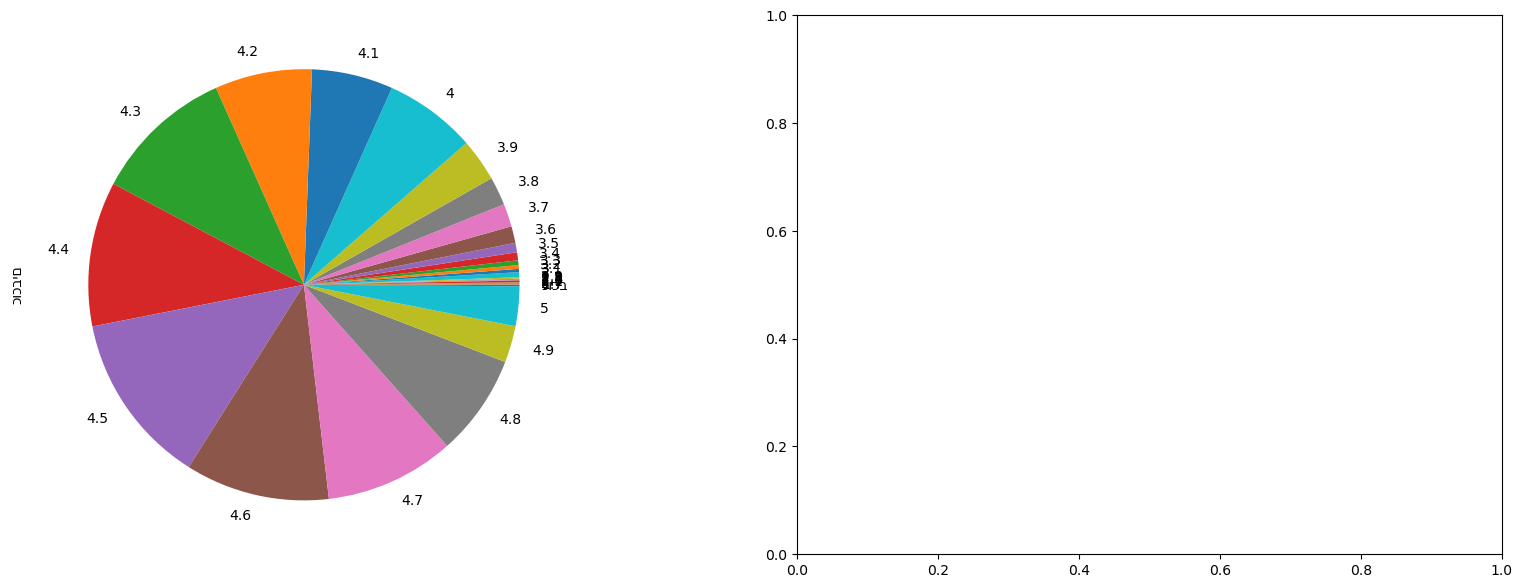

In [26]:
def one_dim_plot(sr, plot_type, axis):
    sr.plot(kind=plot_type, ax=axis)
    
# chart with one variable - distribution of star numbers before cleaning    
df_for_stars = pd.read_csv('C:/Users/maaya/Downloads/books_detalis_worm_include.csv', header=0, sep=',') 
df_for_stars_copy = df_for_stars.copy()
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
series1 = get_frequent_elements(df_for_stars_copy , "כוכבים")
plot1 = one_dim_plot(series1, "pie", axes[0])


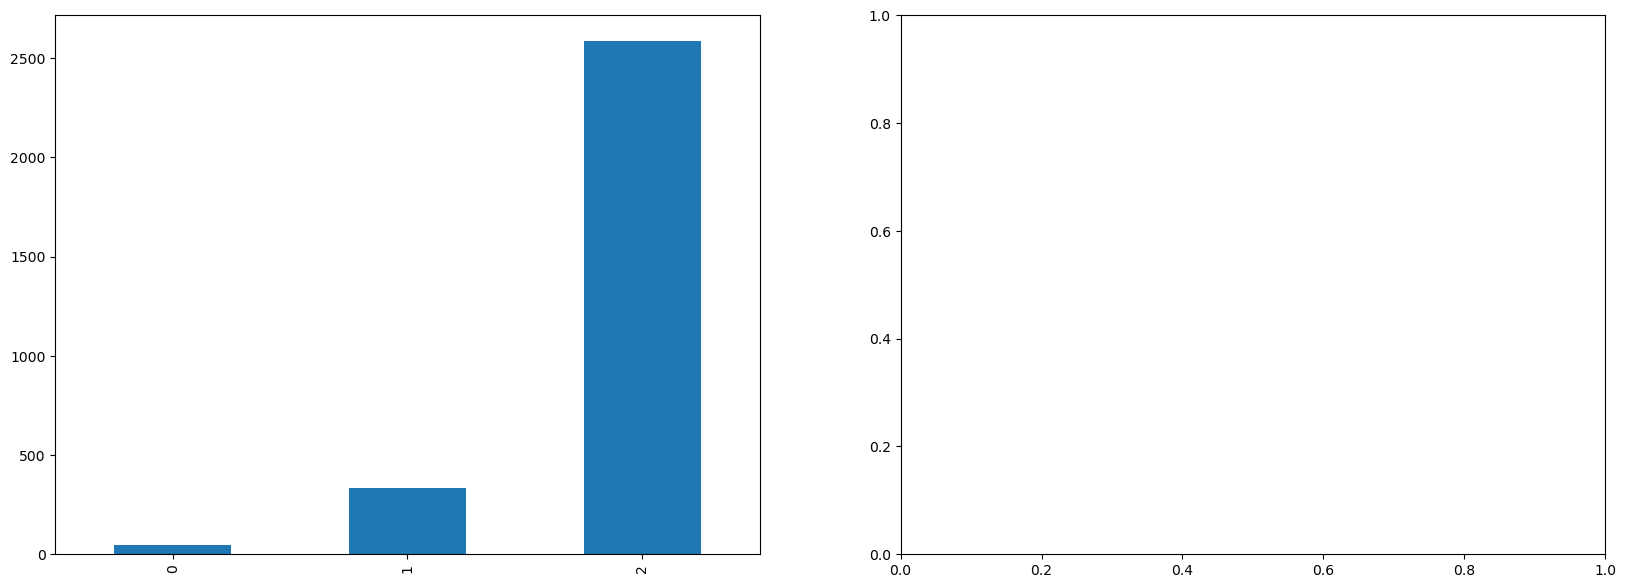

In [27]:
# chart with one variable - distribution of star numbers after cleaning  
df_copy = df_after_cleaning_with_categories.copy()
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
series2 = get_frequent_elements(df_copy, "כוכבים")
plot2 = one_dim_plot(series2, "bar", axes[0])

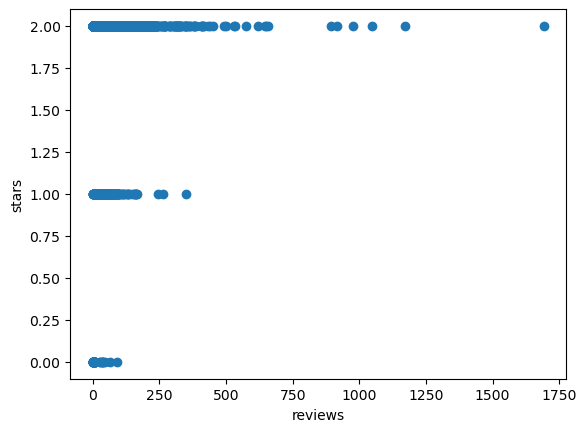

In [28]:
# chart with 2 variables - the number of stars and the number of comments
def two_dim_plot(x, y):
    plt.scatter(x, y)
    plt.xlabel("reviews")
    plt.ylabel("stars")
    
plot3 = two_dim_plot(df_copy["דירוגים"],df_copy["כוכבים"])


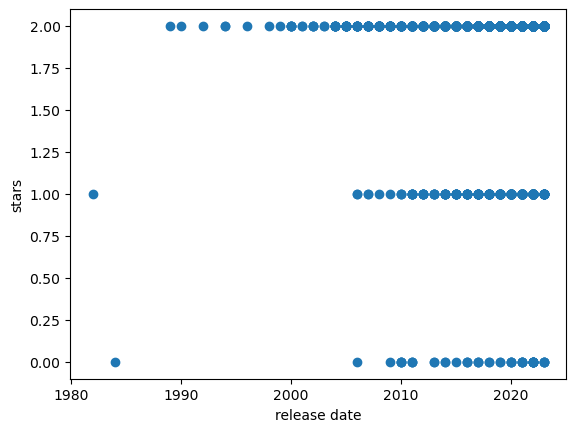

In [29]:
# # chart with 2 variables - number of stars and year of release

def two_dim_plot(x, y):
    plt.scatter(x, y)
    plt.xlabel("release date")
    plt.ylabel("stars")
    
plot4 = two_dim_plot(df_copy["תאריך הוצאה"],df_copy["כוכבים"])


# Machine Learning

In [30]:
# we convert the data frame to numeric.
df_after_cleaning_with_categories.drop(["שם הספר","סופרים","שם הוצאה","נושא"], axis=1, inplace=True)     
df_after_cleaning_with_categories.to_csv('C:/Users/maaya/Downloads/df_all_data_numeric.csv', index=False)

## Supervised learning - Classification Problem.

In [31]:
# Split the data into X_train, X_test, y_train, y_test.
#Origin of code : From our home assignments.
def split_to_train_and_test(X, y, test_ratio, rand_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=rand_state)
    return X_train, X_test, y_train, y_test

def load_dataset(file_name, label_column):
    df_copy = pd.read_csv(file_name)
    TRAINING_FEATURES = df_copy.columns[df_copy.columns != label_column]
    X = df_copy[TRAINING_FEATURES]
    y = df_copy[label_column]
    return X, y

def predict(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    resDF = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
    return resDF

X, y = load_dataset('C:/Users/maaya/Downloads/df_all_data_numeric.csv', "כוכבים")
XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1, test_size=0.2)

# KNN
k = 7
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(XTrain, yTrain)
y_pred = knn.predict(XTest)
knn_accuracy = metrics.accuracy_score(y_true=yTest, y_pred=y_pred)
print(f"KNN Accuracy:", knn_accuracy)

# random Forest
random_state = 1
rf = RandomForestClassifier(random_state=random_state)
rf.fit(XTrain, yTrain)
y_pred = rf.predict(XTest)
rf_accuracy = metrics.accuracy_score(y_true=yTest, y_pred=y_pred)
print(f"Random Forest Accuracy :", rf_accuracy)

# decision Tree
random_state = 3
dt = tree.DecisionTreeClassifier(random_state=random_state)
dt.fit(XTrain, yTrain)
y_pred = dt.predict(XTest)
dt_accuracy = metrics.accuracy_score(y_true=yTest, y_pred=y_pred)
print(f"Decision Tree Accuracy:", dt_accuracy)


C:\Users\maaya\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN Accuracy: 0.8602693602693603
Random Forest Accuracy : 0.8535353535353535
Decision Tree Accuracy: 0.7811447811447811
